<a href="https://colab.research.google.com/github/micposso/12-steps-VR-experience/blob/master/EEG_HomeWork_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout,
    BatchNormalization, concatenate
)
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, AdamW, Adamax
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import (
    EarlyStopping, TensorBoard, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.regularizers import l1_l2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Visualization & utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# EEG data tools
!pip install mne --quiet
import mne

In [21]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mikememo","key":"41958839a1680608f09ba2f9a040f539"}'}

In [22]:
!pip install kaggle --quiet
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [23]:
# Verify Kaggle API setup
!kaggle datasets list -s eeg

ref                                                title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
nnair25/Alcoholics                                 EEG-Alcohol                                          301361416  2017-08-19 14:03:06.177000          11169        125  0.7058824        
jbouv27/eeg                                        EEG Analysis                                           3703343  2019-11-18 01:13:33.840000           3739         59  0.7647059        
wanghaohan/confused-eeg                            Confused student EEG brainwave data                  114134669  2018-03-28 20:52:52.623000          13910        396  0.7941176        
cdeotte/brain-eeg-spectrograms                     Brain-EEG-Spec

In [24]:
!kaggle datasets download -d adibadea/chbmitseizuredataset

Dataset URL: https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset
License(s): GNU Affero General Public License 3.0
chbmitseizuredataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
# See train, test, and val datasets
!unzip chbmitseizuredataset.zip -d chbmitseizuredataset

Archive:  chbmitseizuredataset.zip
replace chbmitseizuredataset/eeg-predictive_train.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chbmitseizuredataset/eeg-predictive_train.npz  
replace chbmitseizuredataset/eeg-predictive_val.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chbmitseizuredataset/eeg-predictive_val.npz  
replace chbmitseizuredataset/eeg-predictive_val_balanced.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chbmitseizuredataset/eeg-predictive_val_balanced.npz  
replace chbmitseizuredataset/eeg-seizure_test.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chbmitseizuredataset/eeg-seizure_test.npz  
replace chbmitseizuredataset/eeg-seizure_train.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace chbmitseizuredataset/eeg-seizure_train.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chbmitseizuredataset/eeg-seizure_train.npz  
replace chbmitseizuredataset/eeg-seizure_val.npz? [y]es, [n]o, [A]ll

In [26]:
#training
data = np.load('chbmitseizuredataset/eeg-seizure_train.npz')
print(list(data.keys()))

['train_signals', 'train_labels']


In [27]:
#testing
data2 = np.load('chbmitseizuredataset/eeg-seizure_test.npz')
print(list(data2.keys()))
2

['test_signals']


2

In [28]:
X = data['train_signals']
y = data['train_labels']

In [29]:
X.shape

(37666, 23, 256)

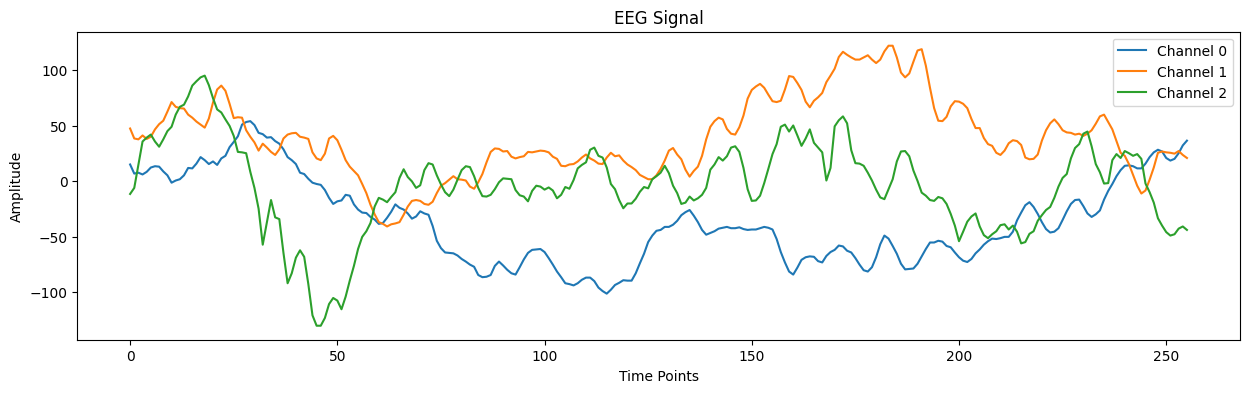

In [30]:
import matplotlib.pyplot as plt

sample_id = 0

plt.figure(figsize=(15, 4))
for channel_id in range(3):
    # Extract the specific EEG signal
    eeg_signal = X[sample_id, channel_id, :]
    plt.plot(eeg_signal, label=f'Channel {channel_id}')

plt.title('EEG Signal')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [31]:
# Question 0: Data Splitting

In [32]:
from sklearn.model_selection import train_test_split

# Load the data
X = data['train_signals']
y = data['train_labels']

# First split: 80% train+val, 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: 75% train, 25% val from the 80% (=> 60% train, 20% val total)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=42
)

In [33]:
#testing
data2 = np.load('chbmitseizuredataset/eeg-seizure_test.npz')
print(list(data2.keys()))

['test_signals']


In [ ]:
# Reshape input: (samples, 23, 256, 1)
X_train = X_train[..., np.newaxis] # shape is (22599, 23, 256, 1)
X_valid = X_valid[..., np.newaxis] # shape is (7533, 23, 256, 1)

# Normalize input
X_train = X_train.astype("float32") / 255.
X_valid = X_valid.astype("float32") / 255.

In [34]:
# Question 1: Sequential API Implementation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 219s 609ms/step - accuracy: 0.7634 - loss: 1.0229 - val_accuracy: 0.7638 - val_loss: 0.8901 - learning_rate: 9.9628e-04
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 248s 571ms/step - accuracy: 0.7952 - loss: 0.3893 - val_accuracy: 0.8035 - val_loss: 0.5323 - learning_rate: 9.9257e-04
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 265s 581ms/step - accuracy: 0.8559 - loss: 0.3350 - val_accuracy: 0.8669 - val_loss: 0.3578 - learning_rate: 9.8887e-04
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 258s 571ms/step - accuracy: 0.8737 - loss: 0.3028 - val_accuracy: 0.8776 - val_loss: 0.3187 - learning_rate: 9.8519e-04
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 190s 535ms/step - accuracy: 0.8847 - loss: 0.2751 - val_accuracy: 0.8959 - val_loss: 0.2769 - learning_rate: 9.8152e-04
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 213s 567ms/step - accuracy: 0.8936 - loss: 0.2621 - val_accuracy: 0.9007 - val_loss: 0.2680 - learning_rate: 9.7787e-04
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 

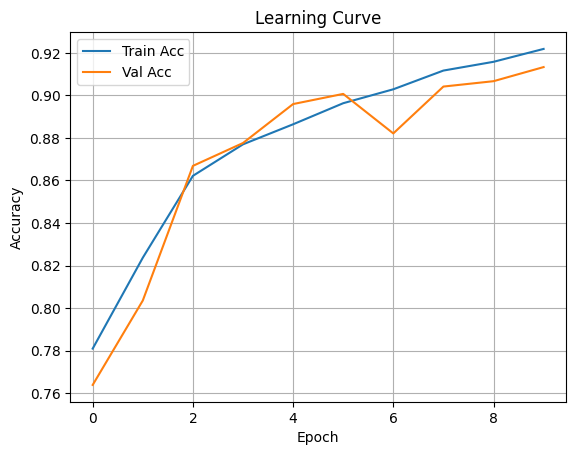

In [35]:
# Sequential API

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(23, 256, 1), kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [ ]:
# Train the model

In [50]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 196s 554ms/step - accuracy: 0.9265 - loss: 0.1821 - val_accuracy: 0.8999 - val_loss: 0.2857
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 201s 550ms/step - accuracy: 0.9285 - loss: 0.1766 - val_accuracy: 0.9136 - val_loss: 0.2445
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 198s 541ms/step - accuracy: 0.9349 - loss: 0.1629 - val_accuracy: 0.9186 - val_loss: 0.2361
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 216s 578ms/step - accuracy: 0.9269 - loss: 0.1944 - val_accuracy: 0.9153 - val_loss: 0.2806
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 255s 561ms/step - accuracy: 0.9400 - loss: 0.1433 - val_accuracy: 0.9162 - val_loss: 0.2646
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 206s 573ms/step - accuracy: 0.9416 - loss: 0.1476 - val_accuracy: 0.9170 - val_loss: 0.2703
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 211s 597ms/step - accuracy: 0.9452 - loss: 0.1396 - val_accuracy: 0.9161 - val_loss: 0.2492
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 241s 539ms/step - accuracy: 0.9417 -

In [ ]:
# Plot the curvers
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve: Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [36]:
# Model 1 Evaluation

In [37]:
# Predict on test set
X_test = X_test[..., np.newaxis].astype("float32") / 255.0
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Average Precision Score
avg_prec = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score: {avg_prec:.4f}")

236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9121 - loss: 0.2468
Validation accuracy: 0.9133


In [38]:
# Question 2: Functional API Implementation

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.7649 - loss: 0.5995 - val_accuracy: 0.8319 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8621 - loss: 0.3460 - val_accuracy: 0.8372 - val_loss: 0.4302 - learning_rate: 0.0010
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8862 - loss: 0.2849 - val_accuracy: 0.8479 - val_loss: 0.4010 - learning_rate: 0.0010
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.9110 - loss: 0.2312 - val_accuracy: 0.8499 - val_loss: 0.4518 - learning_rate: 0.0010
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9280 - loss: 0.1921 - val_accuracy: 0.8611 - val_loss: 0.4494 - learning_rate: 0.0010
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9430 - loss: 0.1556 - val_accuracy: 0.8599 - val_loss: 0.4733 - learning_rate: 0.0010
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9520 - l

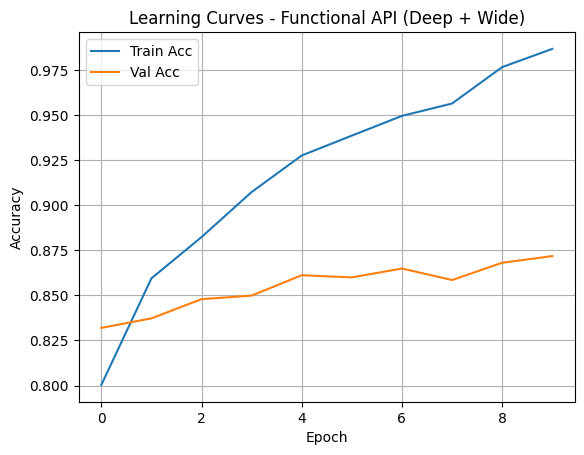

In [39]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model

input_shape = X_train.shape[1:]

# Input layer
input_layer = Input(shape=input_shape)

# Flatten input for wide path
flat = Flatten()(input_layer)

# Wide path (just flattened features)
wide = Dense(300, activation='relu')(flat)

# Deep path
deep = Dense(300, activation='relu')(flat)
deep = BatchNormalization()(deep)
deep = Dropout(0.3)(deep)
deep = Dense(100, activation='relu')(deep)
deep = BatchNormalization()(deep)
deep = Dropout(0.3)(deep)

# Concatenate both paths
merged = concatenate([wide, deep])

# Output layer
output = Dense(1, activation='sigmoid')(merged)

# Build model
model2 = Model(inputs=input_layer, outputs=output)

# Compile
model2.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy']) # Fix: Remove lr_schedule from Adam initialization

# Fit model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)

# Plot learning curves
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curves - Functional API (Deep + Wide)')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Model 2 Evaluation

In [41]:
# Evaluate model
loss2, acc2 = model2.evaluate(X_valid, y_valid)
print(f"Validation Accuracy (Functional API): {acc2:.4f}")

236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8452 - loss: 0.4034
Validation Accuracy (Functional API): 0.8479


In [42]:
# Question 3: Functional API Implementation with Auxiliary

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Define input
input_layer = Input(shape=X_train.shape[1:])

# Flatten for both paths
flat = Flatten()(input_layer)

# Shared base path
hidden1 = Dense(300, activation='relu')(flat)
hidden1 = BatchNormalization()(hidden1)
hidden1 = Dropout(0.5)(hidden1)

hidden2 = Dense(100, activation='relu')(hidden1)
hidden2 = BatchNormalization()(hidden2)
hidden2 = Dropout(0.35)(hidden2)

# Auxiliary output from hidden layer 2
aux_output = Dense(1, activation='sigmoid', name="aux_output")(hidden2)

# Main output
merged = concatenate([flat, hidden2])
final_hidden = Dense(50, activation='relu')(merged)
final_hidden = BatchNormalization()(final_hidden)
main_output = Dense(1, activation='sigmoid', name="main_output")(final_hidden)

# Model
model3 = Model(inputs=input_layer, outputs=[main_output, aux_output])

# Compile
model3.compile(
    loss={"main_output": "binary_crossentropy", "aux_output": "binary_crossentropy"},
    optimizer=Adam(learning_rate=1e-3),
    metrics={"main_output": "accuracy", "aux_output": "accuracy"}
)

# Callbacks
os.makedirs("checkpoints", exist_ok=True)
checkpoint_cb = ModelCheckpoint("checkpoints/best_model_aux.h5", monitor='val_main_output_accuracy', save_best_only=True)

# Stop when epochs are flat
earlystop_cb = EarlyStopping(
    monitor='val_main_output_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# Fit
history3 = model3.fit(
    X_train, [y_train, y_train],
    validation_data=(X_valid, [y_valid, y_valid]),
    epochs=100,
    batch_size=64,
    callbacks=[checkpoint_cb, earlystop_cb]
    # callbacks=[checkpoint_cb]
)


Epoch 1/100
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - aux_output_accuracy: 0.7307 - aux_output_loss: 0.6462 - loss: 1.2679 - main_output_accuracy: 0.7406 - main_output_loss: 0.6217

354/354 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - aux_output_accuracy: 0.7309 - aux_output_loss: 0.6458 - loss: 1.2669 - main_output_accuracy: 0.7409 - main_output_loss: 0.6211 - val_aux_output_accuracy: 0.8254 - val_aux_output_loss: 0.4335 - val_loss: 0.8608 - val_main_output_accuracy: 0.8286 - val_main_output_loss: 0.4271
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - aux_output_accuracy: 0.8152 - aux_output_loss: 0.4511 - loss: 0.8216 - main_output_accuracy: 0.8515 - main_output_loss: 0.3705

354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - aux_output_accuracy: 0.8152 - aux_output_loss: 0.4511 - loss: 0.8216 - main_output_accuracy: 0.8515 - main_output_loss: 0.3705 - val_aux_output_accuracy: 0.8289 - val_aux_output_loss: 0.4135 - val_loss: 0.8221 - val_main_output_accuracy: 0.8354 - val_main_output_loss: 0.4086
Epoch 3/100
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - aux_output_accuracy: 0.8374 - aux_output_loss: 0.4018 - loss: 0.7260 - main_output_accuracy: 0.8695 - main_output_loss: 0.3243

354/354 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - aux_output_accuracy: 0.8373 - aux_output_loss: 0.4018 - loss: 0.7261 - main_output_accuracy: 0.8695 - main_output_loss: 0.3243 - val_aux_output_accuracy: 0.8331 - val_aux_output_loss: 0.3975 - val_loss: 0.7923 - val_main_output_accuracy: 0.8446 - val_main_output_loss: 0.3947
Epoch 4/100
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - aux_output_accuracy: 0.8502 - aux_output_loss: 0.3602 - loss: 0.6385 - main_output_accuracy: 0.8884 - main_output_loss: 0.2783

354/354 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - aux_output_accuracy: 0.8502 - aux_output_loss: 0.3602 - loss: 0.6386 - main_output_accuracy: 0.8884 - main_output_loss: 0.2784 - val_aux_output_accuracy: 0.8435 - val_aux_output_loss: 0.3737 - val_loss: 0.7565 - val_main_output_accuracy: 0.8492 - val_main_output_loss: 0.3824
Epoch 5/100
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - aux_output_accuracy: 0.8585 - aux_output_loss: 0.3341 - loss: 0.5828 - main_output_accuracy: 0.9025 - main_output_loss: 0.2487

354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - aux_output_accuracy: 0.8585 - aux_output_loss: 0.3341 - loss: 0.5829 - main_output_accuracy: 0.9025 - main_output_loss: 0.2488 - val_aux_output_accuracy: 0.8481 - val_aux_output_loss: 0.3668 - val_loss: 0.7499 - val_main_output_accuracy: 0.8517 - val_main_output_loss: 0.3827
Epoch 6/100
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - aux_output_accuracy: 0.8780 - aux_output_loss: 0.2963 - loss: 0.5131 - main_output_accuracy: 0.9160 - main_output_loss: 0.2169

354/354 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - aux_output_accuracy: 0.8780 - aux_output_loss: 0.2963 - loss: 0.5132 - main_output_accuracy: 0.9160 - main_output_loss: 0.2169 - val_aux_output_accuracy: 0.8515 - val_aux_output_loss: 0.3568 - val_loss: 0.7407 - val_main_output_accuracy: 0.8573 - val_main_output_loss: 0.3836
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - aux_output_accuracy: 0.8869 - aux_output_loss: 0.2750 - loss: 0.4649 - main_output_accuracy: 0.9251 - main_output_loss: 0.1899

354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - aux_output_accuracy: 0.8869 - aux_output_loss: 0.2750 - loss: 0.4649 - main_output_accuracy: 0.9251 - main_output_loss: 0.1899 - val_aux_output_accuracy: 0.8577 - val_aux_output_loss: 0.3511 - val_loss: 0.7426 - val_main_output_accuracy: 0.8581 - val_main_output_loss: 0.3913
Epoch 8/100
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - aux_output_accuracy: 0.8965 - aux_output_loss: 0.2552 - loss: 0.4281 - main_output_accuracy: 0.9354 - main_output_loss: 0.1729

354/354 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - aux_output_accuracy: 0.8965 - aux_output_loss: 0.2552 - loss: 0.4282 - main_output_accuracy: 0.9354 - main_output_loss: 0.1730 - val_aux_output_accuracy: 0.8556 - val_aux_output_loss: 0.3517 - val_loss: 0.7324 - val_main_output_accuracy: 0.8599 - val_main_output_loss: 0.3803
Epoch 9/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - aux_output_accuracy: 0.9018 - aux_output_loss: 0.2416 - loss: 0.3987 - main_output_accuracy: 0.9387 - main_output_loss: 0.1570 - val_aux_output_accuracy: 0.8582 - val_aux_output_loss: 0.3512 - val_loss: 0.7530 - val_main_output_accuracy: 0.8592 - val_main_output_loss: 0.4011
Epoch 10/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - aux_output_accuracy: 0.9044 - aux_output_loss: 0.2349 - loss: 0.3827 - main_output_accuracy: 0.9451 - main_output_loss: 0.1479 - val_aux_output_accuracy: 0.8598 - val_aux_output_loss: 0.3510 - val_loss: 0.7600 - val_main_output_accuracy: 0.8585 - val_main_output_loss: 0.4086
Epoch 11/100

354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - aux_output_accuracy: 0.9122 - aux_output_loss: 0.2189 - loss: 0.3524 - main_output_accuracy: 0.9502 - main_output_loss: 0.1335 - val_aux_output_accuracy: 0.8630 - val_aux_output_loss: 0.3526 - val_loss: 0.7668 - val_main_output_accuracy: 0.8626 - val_main_output_loss: 0.4137
Epoch 12/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - aux_output_accuracy: 0.9104 - aux_output_loss: 0.2116 - loss: 0.3256 - main_output_accuracy: 0.9582 - main_output_loss: 0.1140

354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - aux_output_accuracy: 0.9104 - aux_output_loss: 0.2116 - loss: 0.3257 - main_output_accuracy: 0.9582 - main_output_loss: 0.1141 - val_aux_output_accuracy: 0.8606 - val_aux_output_loss: 0.3580 - val_loss: 0.7838 - val_main_output_accuracy: 0.8639 - val_main_output_loss: 0.4254
Epoch 13/100
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - aux_output_accuracy: 0.9193 - aux_output_loss: 0.1986 - loss: 0.3049 - main_output_accuracy: 0.9601 - main_output_loss: 0.1063

354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - aux_output_accuracy: 0.9193 - aux_output_loss: 0.1986 - loss: 0.3050 - main_output_accuracy: 0.9601 - main_output_loss: 0.1064 - val_aux_output_accuracy: 0.8633 - val_aux_output_loss: 0.3569 - val_loss: 0.7849 - val_main_output_accuracy: 0.8654 - val_main_output_loss: 0.4274
Epoch 14/100
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - aux_output_accuracy: 0.9225 - aux_output_loss: 0.1994 - loss: 0.3052 - main_output_accuracy: 0.9619 - main_output_loss: 0.1057

354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - aux_output_accuracy: 0.9225 - aux_output_loss: 0.1995 - loss: 0.3052 - main_output_accuracy: 0.9619 - main_output_loss: 0.1057 - val_aux_output_accuracy: 0.8670 - val_aux_output_loss: 0.3594 - val_loss: 0.8089 - val_main_output_accuracy: 0.8663 - val_main_output_loss: 0.4489
Epoch 15/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - aux_output_accuracy: 0.9261 - aux_output_loss: 0.1892 - loss: 0.2881 - main_output_accuracy: 0.9640 - main_output_loss: 0.0989 - val_aux_output_accuracy: 0.8619 - val_aux_output_loss: 0.3750 - val_loss: 0.8422 - val_main_output_accuracy: 0.8622 - val_main_output_loss: 0.4667
Epoch 16/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - aux_output_accuracy: 0.9287 - aux_output_loss: 0.1804 - loss: 0.2703 - main_output_accuracy: 0.9685 - main_output_loss: 0.0898

354/354 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - aux_output_accuracy: 0.9286 - aux_output_loss: 0.1805 - loss: 0.2703 - main_output_accuracy: 0.9685 - main_output_loss: 0.0899 - val_aux_output_accuracy: 0.8694 - val_aux_output_loss: 0.3580 - val_loss: 0.8000 - val_main_output_accuracy: 0.8694 - val_main_output_loss: 0.4418
Epoch 17/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - aux_output_accuracy: 0.9317 - aux_output_loss: 0.1700 - loss: 0.2506 - main_output_accuracy: 0.9706 - main_output_loss: 0.0806 - val_aux_output_accuracy: 0.8647 - val_aux_output_loss: 0.3658 - val_loss: 0.8343 - val_main_output_accuracy: 0.8623 - val_main_output_loss: 0.4679
Epoch 18/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - aux_output_accuracy: 0.9352 - aux_output_loss: 0.1708 - loss: 0.2418 - main_output_accuracy: 0.9749 - main_output_loss: 0.0710 - val_aux_output_accuracy: 0.8674 - val_aux_output_loss: 0.3598 - val_loss: 0.8442 - val_main_output_accuracy: 0.8645 - val_main_output_loss: 0.4838
Epoch 19/10

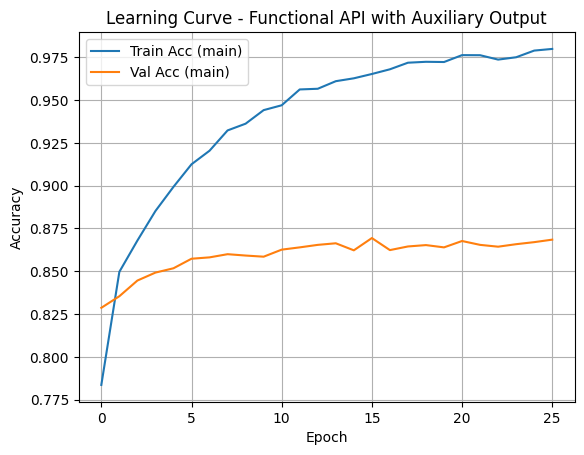

In [61]:
# Plot learning curves for main output
plt.plot(history3.history['main_output_accuracy'], label='Train Acc (main)')
plt.plot(history3.history['val_main_output_accuracy'], label='Val Acc (main)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Functional API with Auxiliary Output')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# Model 3 Evaluation

In [62]:
# Evaluate model3
results = model3.evaluate(X_valid, [y_valid, y_valid])
print(f"Main Output Accuracy: {results[3]:.4f}")  # main_output_accuracy is at index 3
print(f"Auxiliary Output Accuracy: {results[4]:.4f}")


236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - aux_output_accuracy: 0.8690 - aux_output_loss: 0.3607 - loss: 0.8140 - main_output_accuracy: 0.8678 - main_output_loss: 0.4533
Main Output Accuracy: 0.8694
Auxiliary Output Accuracy: 0.8694


In [47]:
# Compate models in a table

In [64]:
import pandas as pd

# Build comparison table
comparison_df = pd.DataFrame({
    "Model": ["Model 1: Sequential CNN",
              "Model 2: Functional (Wide & Deep)",
              "Model 3: Functional + Auxiliary"],
    "Validation Accuracy": [acc, acc2, results[3]],
    "Auxiliary Accuracy": [None, None, results[4]],
    "Loss": [loss, loss2, results[0]]
})

# Show comparison table
print("Model Comparison Table:")
display(comparison_df)

Model Comparison Table:


,Model,Validation Accuracy,Auxiliary Accuracy,Loss
0,Model 1: Sequential CNN,0.913315,NaN,0.245034
1,Model 2: Functional (Wide & Deep),0.847869,NaN,0.400979
2,Model 3: Functional + Auxiliary,0.869375,0.869375,0.800041


In [ ]:
# Genearte CVS file for Kaggle competition

In [65]:
# Step 1: Preprocess test data (use same normalization and shape)
X_test = X_test[..., np.newaxis]  # Add channel dimension
X_test = X_test.astype("float32") / 255.0

# Step 2: Predict using main output of Model 3
y_pred_proba = model3.predict(X_test)[0].flatten()  # [0] = main_output

# Step 3: Create DataFrame for submission
submission_df = pd.DataFrame({
    "Id": np.arange(len(y_pred_proba)),
    "Predicted": y_pred_proba
})

# Step 4: Save as CSV
submission_df.to_csv("module5)submission.csv", index=False)
print("submission.csv has been saved.")


236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
submission.csv has been saved.
